<a href="https://colab.research.google.com/github/SayatAbdikul/Food_classification/blob/main/food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing PyTorch and setting up device-agnostic code

In [55]:
import torch
from torch import nn


In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Get data

In [57]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} already exists, skipping download.")
else:
  print(f"{image_path} directory does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)
# Downloading the data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzipping the downloaded file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi already exists, skipping download.
Unzipping pizza, steak, sushi data...


# Data preparation and exploration

In [58]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [59]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualizing and image

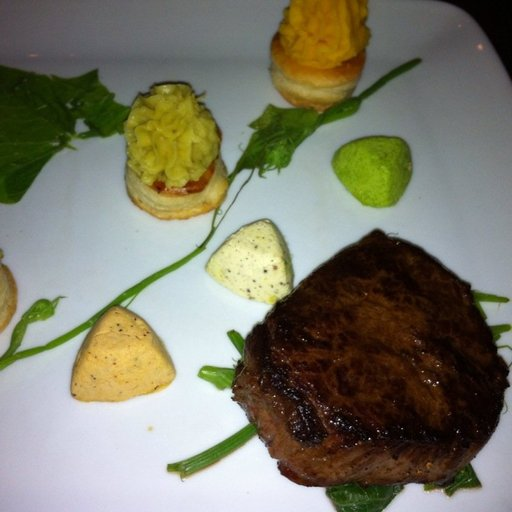

In [60]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img


Text(0.5, 1.0, 'Image class: steak')

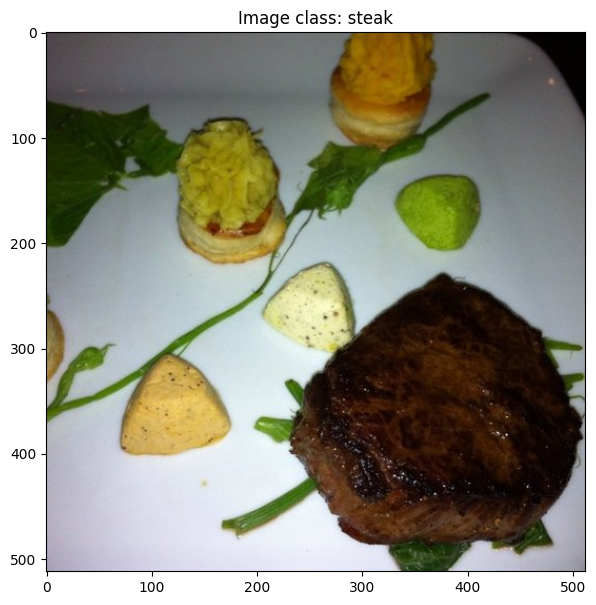

In [61]:
import numpy as np
import matplotlib.pyplot as plt
img_array = np.array(img)
plt.figure(figsize=(10, 7))
plt.imshow(img_array)
plt.title(f"Image class: {image_class}")

# Transforming data

In [62]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [63]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
  ]
  )
data_transform(img).shape

torch.Size([3, 64, 64])

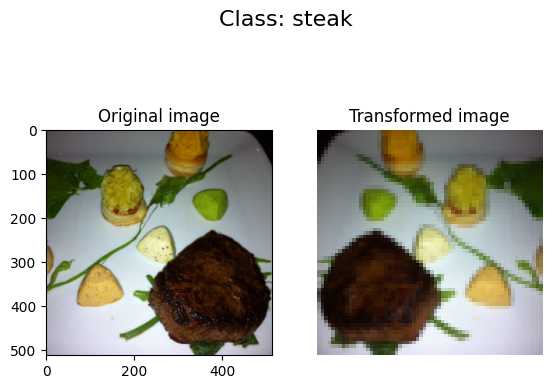

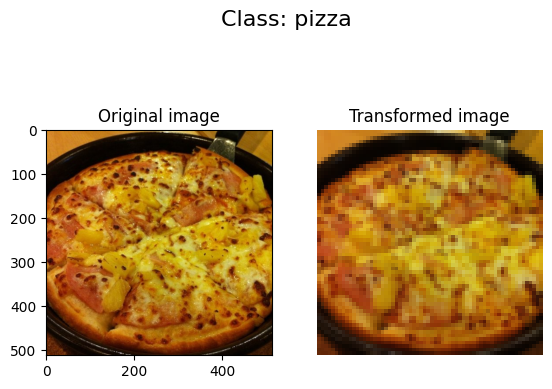

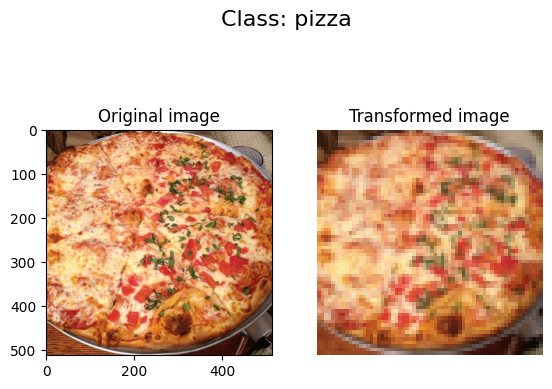

In [64]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original image")
      ax[0].axis = False
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed image")
      ax[1].axis("off")
      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
plot_transformed_images(image_path_list, data_transform, n=3, seed=42)


# Loading image data using ImageFolder

In [65]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)


In [66]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)



In [67]:
from torchvision import datasets
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
  ]
  )
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
  ]
  )

In [68]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/971934.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/930553.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg')]

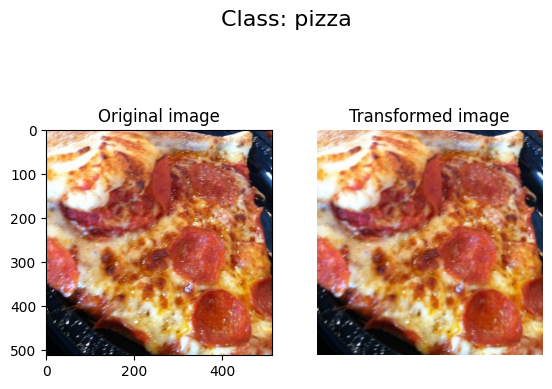

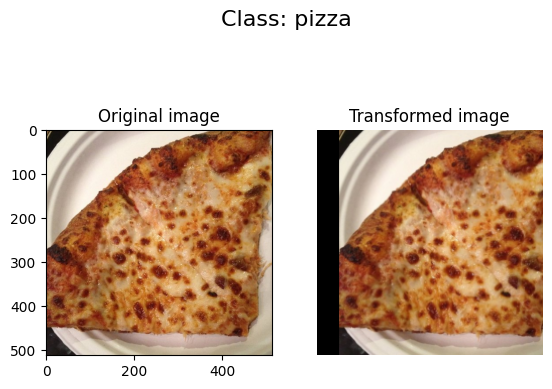

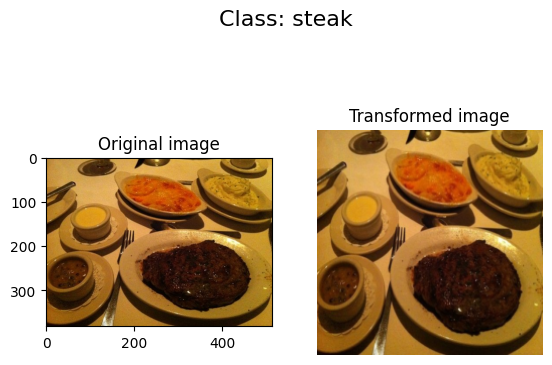

In [69]:
plot_transformed_images(image_path_list, train_transform, n=3, seed=None)

# Model 0: TinyVGG without data augmentation

## Transform

In [70]:
simple_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor(),
    ]
)

In [71]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7f35bff4df00>,
 <torch.utils.data.dataloader.DataLoader at 0x7f35bff4c5b0>)

## Model

In [72]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # default stride is the same as kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # default stride is the same as kernel size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
    )
  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [73]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_simple.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

## Try a forward pass on a single image

In [74]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch = image_batch.to(device)
label_batch = label_batch.to(device)
model_0(image_batch)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

## Using the `torchinfo` for getting complete information about the model

In [75]:
try :
  from torchinfo import summary
except :
  !pip install torchinfo
  from torchinfo import summary
summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## Helper functions

In [76]:
def train_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             optimizer: torch.optim.Optimizer,
             device: torch.device = device):
  model.train()
  model.to(device)
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [77]:
def test_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device = device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            test_loss += loss_fn(test_pred_logits, y)
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [78]:
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
        epochs: int = 5,
        device: torch.device = device):
  results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
            }
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer, device=device)
    print(f"Train loss: {train_loss} | Train acc: {(train_acc*100):.2f}")
    test_loss, test_acc = test_step(model=model,
                                   dataloader=test_dataloader,
                                   loss_fn=loss_fn, device=device)
    print(f"Test loss: {test_loss} | Test acc: {(test_acc*100):.2f}")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results

## Training and testing the model

In [79]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_simple.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
from timeit import default_timer as timer
start_time = timer()
NUM_EPOCHS = 5
model_0_results = train(model=model_0, epochs=NUM_EPOCHS, train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple, optimizer=optimizer)
print(f"Total training time: {timer() - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.106319084763527 | Train acc: 30.47
Test loss: 1.098320484161377 | Test acc: 30.11
Epoch: 1
---------
Train loss: 1.0998057276010513 | Train acc: 32.81
Test loss: 1.069690227508545 | Test acc: 54.17
Epoch: 2
---------
Train loss: 1.0868544578552246 | Train acc: 48.83
Test loss: 1.0807572603225708 | Test acc: 49.24
Epoch: 3
---------
Train loss: 1.0842333137989044 | Train acc: 39.84
Test loss: 1.060831904411316 | Test acc: 58.33
Epoch: 4
---------
Train loss: 1.0662163347005844 | Train acc: 41.41
Test loss: 1.0653959512710571 | Test acc: 56.44
Total training time: 21.236 seconds


In [80]:
test_loss, test_acc = test_step(model=model_0, dataloader=test_dataloader_simple, loss_fn=loss_fn)
print(f"test_loss: {test_loss:.5f}, test_acc: {test_acc:.5f}")

test_loss: 1.06540, test_acc: 0.56439


## Plot the loss curves of Model 0

In [81]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [82]:
def to_cpu_numpy(tensor):
        if isinstance(tensor, torch.Tensor):
            return tensor.cpu().numpy()
        return tensor

In [83]:

def plot_loss_curves(results: dict[str, list[float]]):
    train_loss = [to_cpu_numpy(x) for x in results["train_loss"]]
    test_loss = [to_cpu_numpy(x) for x in results["test_loss"]]
    train_acc = [to_cpu_numpy(x) for x in results["train_acc"]]
    test_acc = [to_cpu_numpy(x) for x in results["test_acc"]]

    epochs = range(len(train_loss))

    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, test_loss, label="Test loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train accuracy")
    plt.plot(epochs, test_acc, label="Test accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

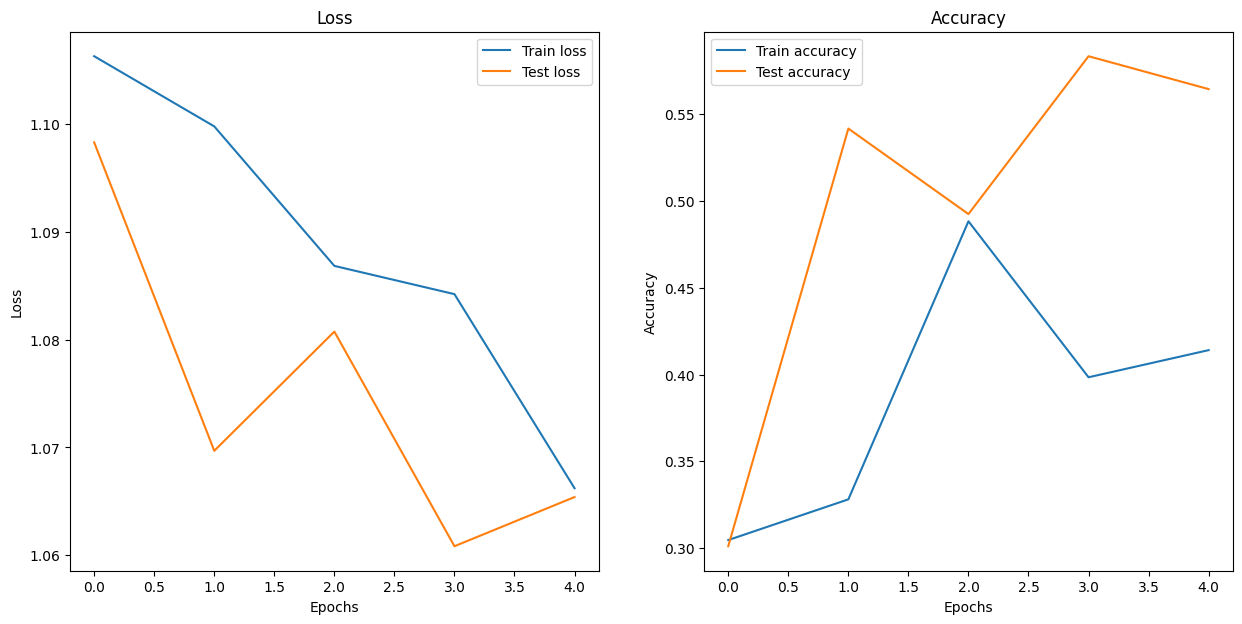

In [84]:
plot_loss_curves(model_0_results)

# TinyVGG with data augmentation

In [85]:
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
  ]
  )
test_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
  ]
  )

In [86]:
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir, transform=train_transform_trivial, target_transform=None)
test_data_augmented = datasets.ImageFolder(root=test_dir, transform=test_transform_trivial, target_transform=None)

In [87]:
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_loader = DataLoader(dataset=train_data_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(dataset=test_data_augmented, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
print(len(train_loader))
print(len(test_loader))

8
3


## Construct and train model 1

In [88]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_augmented.classes)).to(device)
NUM_EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
from timeit import default_timer as timer
start_time = timer()
model_1_results = train(model=model_1, epochs=NUM_EPOCHS, train_dataloader=train_loader, test_dataloader=test_loader,
                        optimizer=optimizer)
print(f"Total training time: {timer() - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.1069144010543823 | Train acc: 30.47
Test loss: 1.0992883443832397 | Test acc: 27.08
Epoch: 1
---------
Train loss: 1.1019357740879059 | Train acc: 32.03
Test loss: 1.0718879699707031 | Test acc: 54.17
Epoch: 2
---------
Train loss: 1.0916990786790848 | Train acc: 43.75
Test loss: 1.084630012512207 | Test acc: 49.24
Epoch: 3
---------
Train loss: 1.0915484577417374 | Train acc: 31.25
Test loss: 1.06777822971344 | Test acc: 58.33
Epoch: 4
---------
Train loss: 1.0861908793449402 | Train acc: 35.94
Test loss: 1.075107455253601 | Test acc: 53.31
Total training time: 11.329 seconds


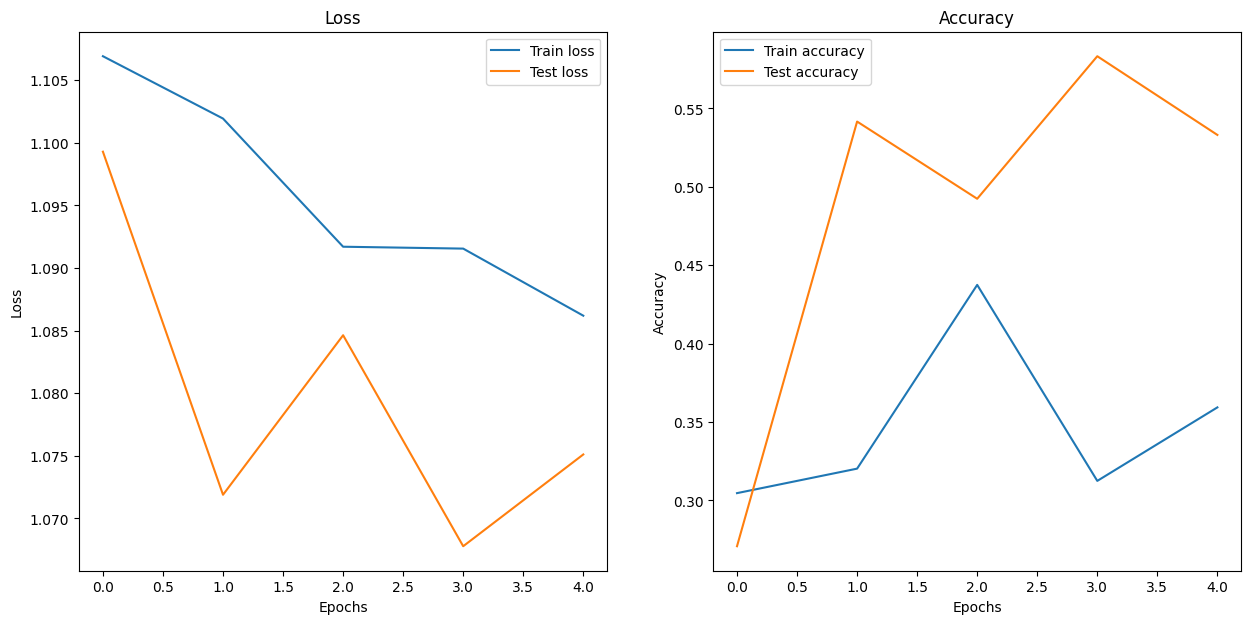

In [89]:
plot_loss_curves(results=model_1_results)

# Compare model results

In [90]:
def to_cpu_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.cpu().numpy()
    return tensor

def convert_results_to_cpu(results: dict[str, list[float]]) -> dict[str, list[float]]:
    return {key: [to_cpu_numpy(x) for x in value] for key, value in results.items()}

model_0_results = convert_results_to_cpu(model_0_results)
model_1_results = convert_results_to_cpu(model_1_results)

In [91]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.0983205,0.301136
1,1.099806,0.328125,1.0696902,0.541667
2,1.086854,0.488281,1.0807573,0.492424
3,1.084233,0.398438,1.0608319,0.583333
4,1.066216,0.414062,1.065396,0.564394


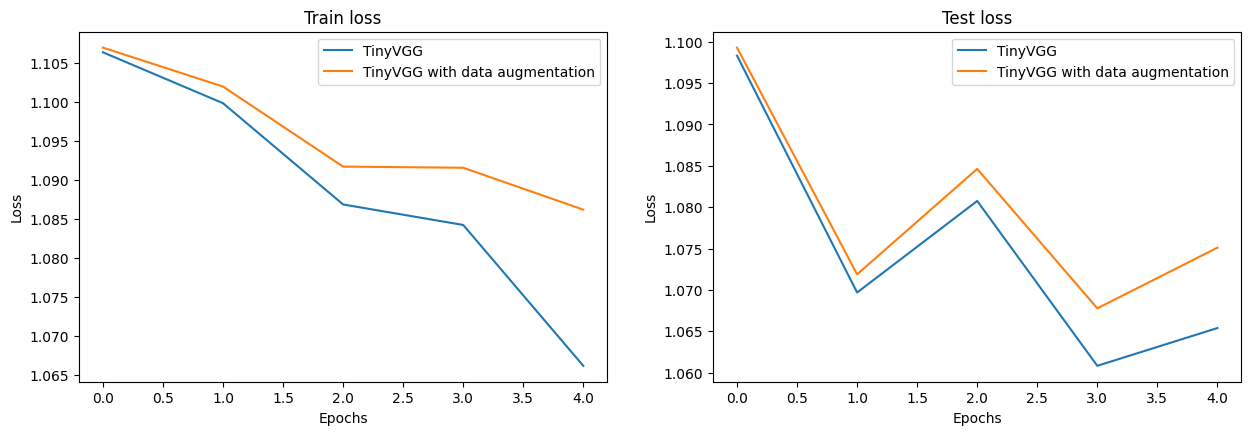

In [92]:
# Setting up a plot
plt.figure(figsize=(15, 10))
epochs = range(len(model_0_df))
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="TinyVGG")
plt.plot(epochs, model_1_df["train_loss"], label="TinyVGG with data augmentation")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="TinyVGG")
plt.plot(epochs, model_1_df["test_loss"], label="TinyVGG with data augmentation")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Making a prediction on a custom image

In [93]:
import requests
custom_image_path = data_path / "04-pizza-dad.jpeg"
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
      request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
      f.write(request.content)
      print("Downloaded custom image...")
else:
    print("Custom image already exists.")
custom_image = Image.open(custom_image_path)

Custom image already exists.


In [98]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(custom_image_path)
custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32) / 255


In [105]:
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
  ]
  )
custom_image = custom_image_transform(custom_image)
custom_image.shape

torch.Size([3, 64, 64])

In [108]:
custom_image.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [114]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image.unsqueeze(0).to(device))
custom_image_pred

tensor([[-0.1157, -0.0199, -0.0052]])

In [115]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3108, 0.3421, 0.3471]])

In [116]:
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_label

tensor([2])

In [117]:
class_names = train_data_augmented.classes
class_names[custom_image_pred_label]

'sushi'

In [121]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: list[str] = None,
                        transform = None,
                        device=device):
  target_image = torchvision.io.read_image(image_path).type(torch.float32) / 255
  if transform:
    target_image = transform(target_image)
  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_image_pred = model(target_image.unsqueeze(0).to(device))
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
  plt.imshow(target_image.permute(1, 2, 0))
  if class_names:
    plt.title(f"Pred: {class_names[target_image_pred_label]}")
  else:
    plt.title(f"Pred: {target_image_pred_label}")

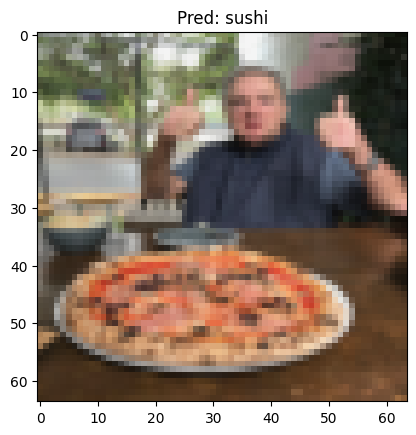

In [122]:
pred_and_plot_image(model=model_1, image_path=custom_image_path,
                    class_names=class_names, transform=custom_image_transform)